In [28]:
import warnings
import pandas as pd
import mplfinance as mpf
import numpy as np

import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST

from trainer import fit
from datasets import SiameseMNIST, TripletMNIST, BalancedBatchSampler
from metrics import AccumulatedAccuracyMetric, AverageNonzeroTripletsMetric
from networks import EmbeddingNet, ClassificationNet, SiameseNet, TripletNet
from losses import ContrastiveLoss, TripletLoss, OnlineContrastiveLoss, OnlineTripletLoss

from utils import HardNegativePairSelector  # Strategies for selecting pairs within a minibatch
from utils import RandomNegativeTripletSelector  # Strategies for selecting triplets within a minibatch
warnings.filterwarnings("ignore")


In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
buy_patterns_clusters = np.load('/siamese-triplet/data/buy_patterns_clusters.npy')
buy_patterns = np.load('/siamese-triplet/data/buy_patterns.npy')
sell_patterns_clusters = np.load('/siamese-triplet/data/sell_patterns_clusters.npy')
sell_patterns = np.load('/siamese-triplet/data/sell_patterns.npy')

print(f'buy_patterns_clusters shape: {buy_patterns_clusters.shape}')
print(f'buy_patterns shape: {buy_patterns.shape}')
print(f'sell_patterns_clusters shape: {sell_patterns_clusters.shape}')
print(f'sell_patterns shape: {sell_patterns.shape}')

buy_patterns_clusters shape: (30,)
buy_patterns shape: (30, 60, 5)
sell_patterns_clusters shape: (25,)
sell_patterns shape: (25, 60, 5)


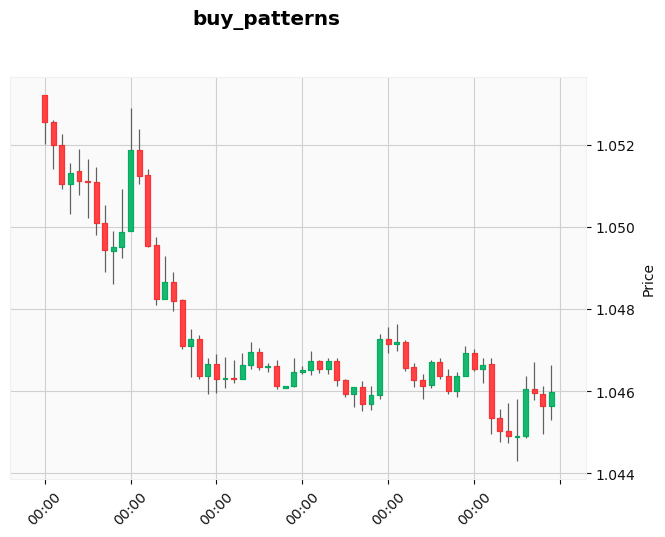

In [31]:
data_buy = pd.DataFrame({
    'Date': [i for i in range(buy_patterns[:,:,0][0].shape[0])],
    'Open': buy_patterns[:,:,0][0],
    'High': buy_patterns[:,:,1][0],
    'Low': buy_patterns[:,:,2][0],
    'Close': buy_patterns[:,:,3][0],
    'Volume': buy_patterns[:,:,4][0]
})

data_buy['Date'] = pd.to_datetime(data_buy['Date'])
data_buy.set_index('Date', inplace=True)

mpf.plot(data_buy, type='candle', style='yahoo', title='buy_patterns')


In [32]:
buy_patterns_clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

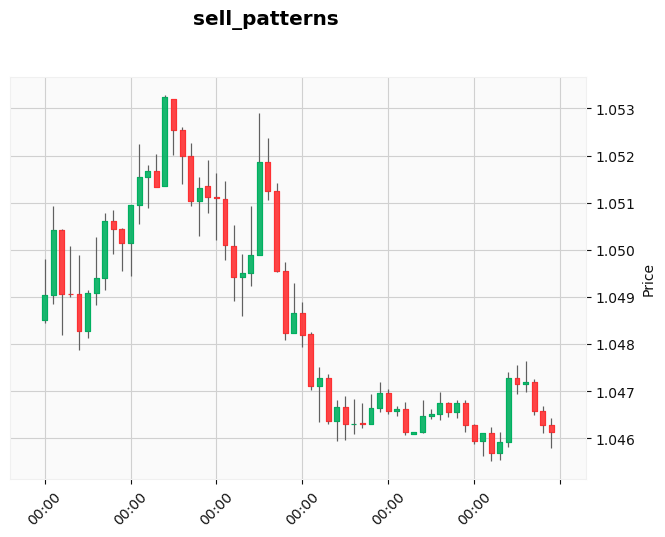

In [33]:
data_sell = pd.DataFrame({
    'Date': [i for i in range(buy_patterns[:,:,0][0].shape[0])],
    'Open': sell_patterns[:,:,0][0],
    'High': sell_patterns[:,:,1][0],
    'Low': sell_patterns[:,:,2][0],
    'Close': sell_patterns[:,:,3][0],
    'Volume': sell_patterns[:,:,4][0]
})


data_sell['Date'] = pd.to_datetime(data_sell['Date'])
data_sell.set_index('Date', inplace=True)
data_sell['Open']

mpf.plot(data_sell, type='candle', style='yahoo', title='sell_patterns')


In [34]:
n_classes = 4
mnist_classes = ['0', '1', '2', '3']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
cuda = torch.cuda.is_available()

def plot_embeddings(embeddings, targets, title=None, xlim=None, ylim=None):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)
    plt.title(title)
    plt.show()

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [35]:
from sklearn.model_selection import train_test_split


x = np.concatenate([buy_patterns, sell_patterns]).reshape(55, 1, 60, 5)
y = np.concatenate([buy_patterns_clusters, sell_patterns_clusters+2])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    shuffle=True, stratify=y, random_state=29)

train_dataset = [(torch.from_numpy(x_train[i]).double(), torch.tensor(y_train[i], dtype=torch.long)) for i in range(len(y_train))]
test_dataset = [(torch.from_numpy(x_test[i]).double(), torch.tensor(y_test[i], dtype=torch.long)) for i in range(len(y_test))]

x_train = torch.from_numpy(x_train).double()
x_test = torch.from_numpy(x_test).double()
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


1. Baseline - classification with softmax:
Train: [0/44 (0%)]	Loss: 4.899406	Accuracy: 6.25

Epoch: 1/20. Train set: Average loss: 820.8421	Accuracy: 11.363636363636363
Epoch: 1/20. Validation set: Average loss: 42523.8679	Accuracy: 18.181818181818183
Train: [0/44 (0%)]	Loss: 44970.394172	Accuracy: 18.75

Epoch: 2/20. Train set: Average loss: 19119.0886	Accuracy: 13.636363636363637
Epoch: 2/20. Validation set: Average loss: 217.4806	Accuracy: 18.181818181818183
Train: [0/44 (0%)]	Loss: 333.125771	Accuracy: 6.25

Epoch: 3/20. Train set: Average loss: 243.7472	Accuracy: 18.181818181818183
Epoch: 3/20. Validation set: Average loss: 532.7343	Accuracy: 18.181818181818183
Train: [0/44 (0%)]	Loss: 470.512269	Accuracy: 12.5

Epoch: 4/20. Train set: Average loss: 789.5173	Accuracy: 13.636363636363637
Epoch: 4/20. Validation set: Average loss: 746.4049	Accuracy: 36.36363636363637
Train: [0/44 (0%)]	Loss: 837.970412	Accuracy: 25.0

Epoch: 5/20. Train set: Average loss: 562.7533	Accuracy: 40.9090

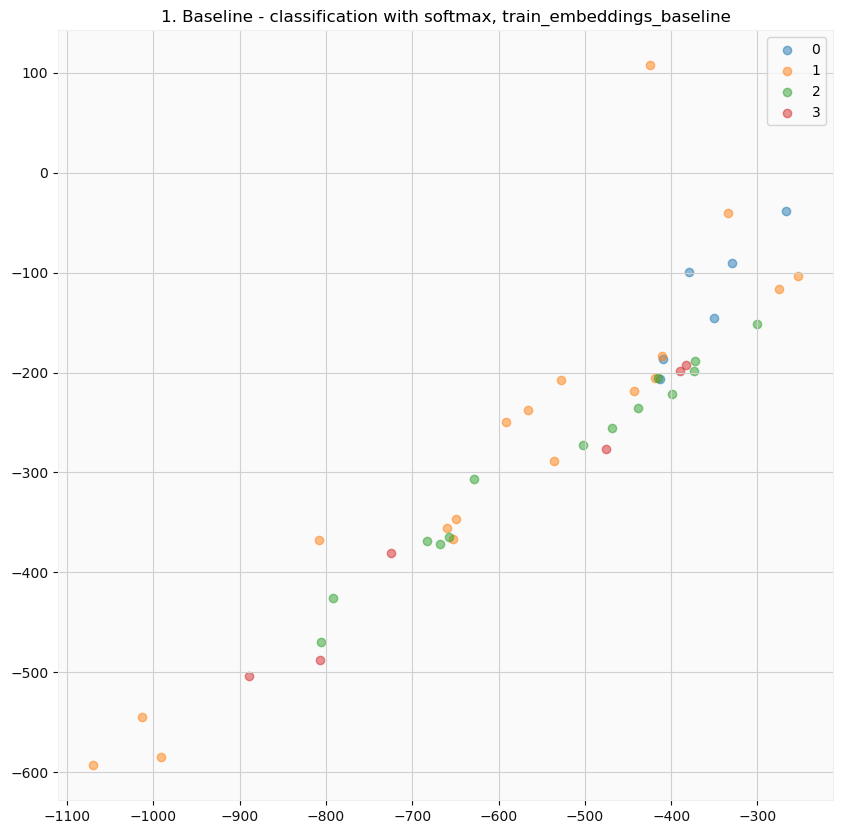

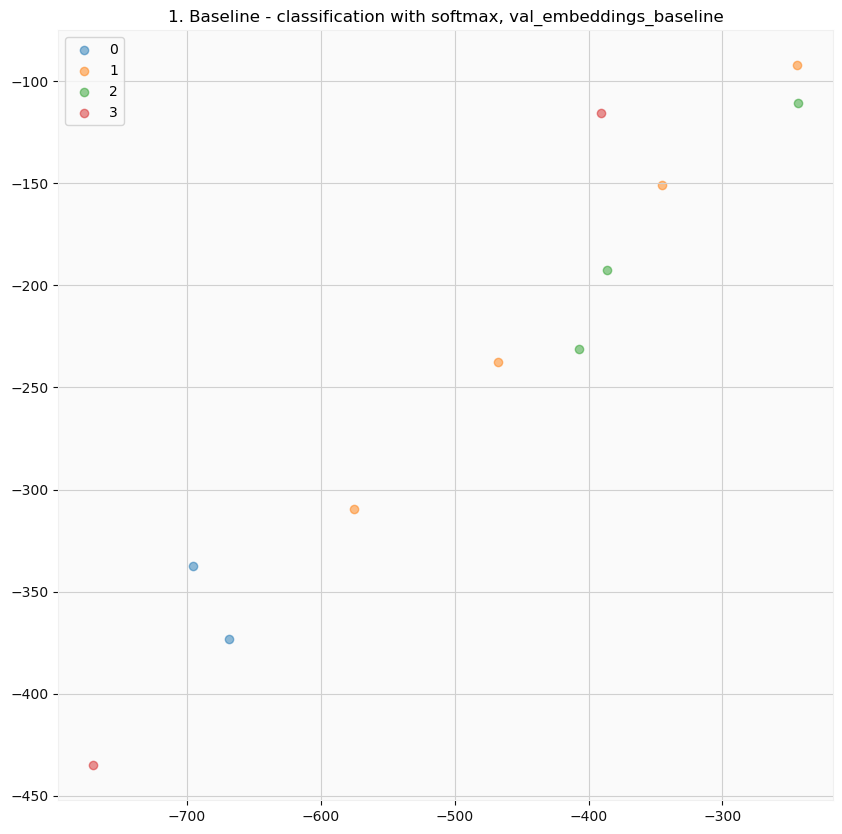

In [36]:
# Baseline: Classification with softmax
# We'll train the model for classification and use outputs of penultimate layer as embeddings
# Set up data loaders
title = '1. Baseline - classification with softmax'
print(f'\n{title}:')
batch_size = 16
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
embedding_net = EmbeddingNet().double()
model = ClassificationNet(embedding_net, n_classes=n_classes).double()
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval,
    metrics=[AccumulatedAccuracyMetric()])

train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline, f'{title}, train_embeddings_baseline')
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline, f'{title}, val_embeddings_baseline')


2. Siamese network:
Train: [0/44 (0%)]	Loss: 33.665372

Epoch: 1/20. Train set: Average loss: 1139.3045
Epoch: 1/20. Validation set: Average loss: 716.4215
Train: [0/44 (0%)]	Loss: 560.638282

Epoch: 2/20. Train set: Average loss: 653.9884
Epoch: 2/20. Validation set: Average loss: 65.0496
Train: [0/44 (0%)]	Loss: 147.802266

Epoch: 3/20. Train set: Average loss: 168.4196
Epoch: 3/20. Validation set: Average loss: 67.6334
Train: [0/44 (0%)]	Loss: 58.141173

Epoch: 4/20. Train set: Average loss: 74.3298
Epoch: 4/20. Validation set: Average loss: 25.4802
Train: [0/44 (0%)]	Loss: 24.160685

Epoch: 5/20. Train set: Average loss: 31.3140
Epoch: 5/20. Validation set: Average loss: 10.7995
Train: [0/44 (0%)]	Loss: 34.807499

Epoch: 6/20. Train set: Average loss: 27.3971
Epoch: 6/20. Validation set: Average loss: 4.7396
Train: [0/44 (0%)]	Loss: 10.914831

Epoch: 7/20. Train set: Average loss: 11.2504
Epoch: 7/20. Validation set: Average loss: 2.3057
Train: [0/44 (0%)]	Loss: 17.367119

Epoch: 

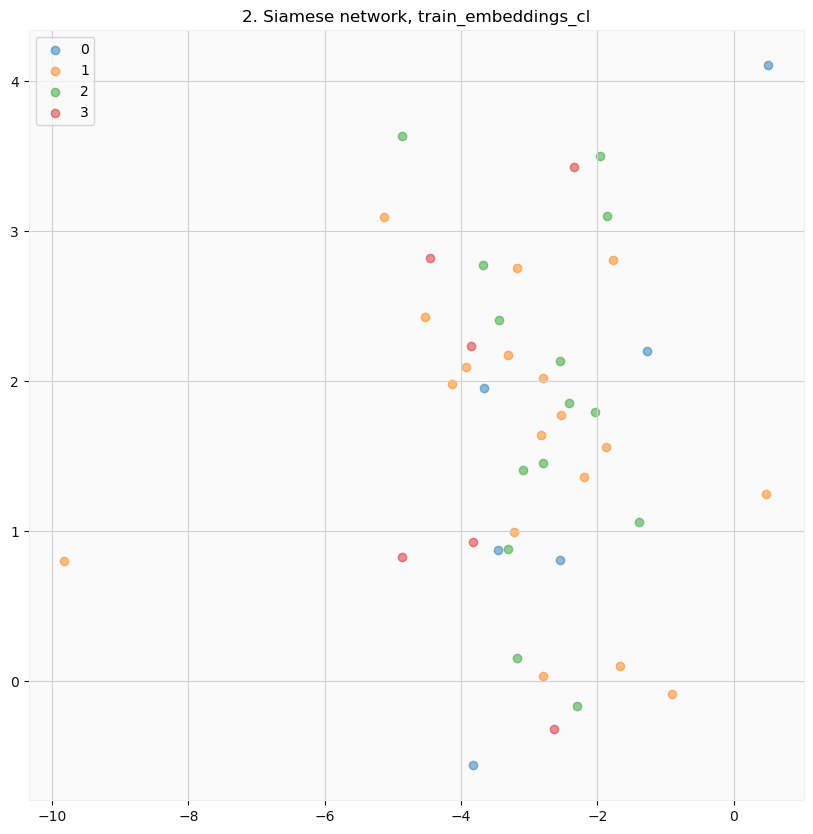

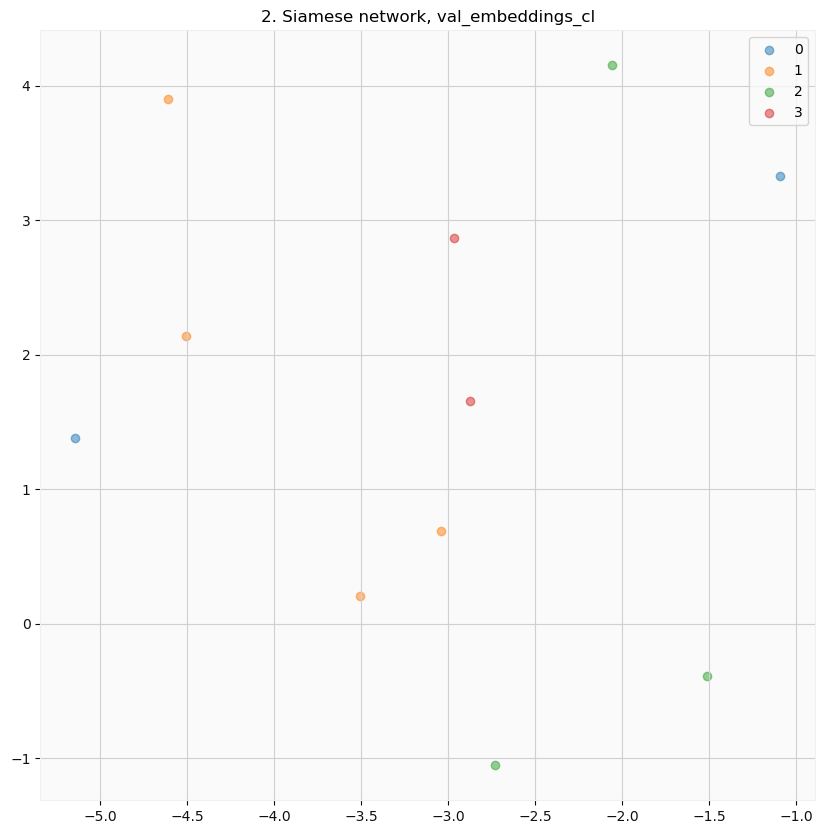

In [37]:
cuda = torch.cuda.is_available()

title = '2. Siamese network'
print(f'\n{title}:')
siamese_train_dataset = SiameseMNIST(x=x_train, y=y_train, train=True) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(x=x_test, y=y_test, train=False)
batch_size = 16
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


# Set up the network and training parameters
margin = 1.
embedding_net = EmbeddingNet().double()
model = SiameseNet(embedding_net).double()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

fit(siamese_train_loader, siamese_test_loader, model,
     loss_fn, optimizer, scheduler, n_epochs, cuda,
       log_interval)

train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl, f'{title}, train_embeddings_cl')
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl, f'{title}, val_embeddings_cl')


3. Triplet network:
Train: [0/44 (0%)]	Loss: 110.482996

Epoch: 1/5. Train set: Average loss: 13772.3418
Epoch: 1/5. Validation set: Average loss: 1179.6821
Train: [0/44 (0%)]	Loss: 14489.498186

Epoch: 2/5. Train set: Average loss: 7289.1431
Epoch: 2/5. Validation set: Average loss: 493.7057
Train: [0/44 (0%)]	Loss: 7493.237230

Epoch: 3/5. Train set: Average loss: 3509.5278
Epoch: 3/5. Validation set: Average loss: 7.5235
Train: [0/44 (0%)]	Loss: 519.489311

Epoch: 4/5. Train set: Average loss: 645.9239
Epoch: 4/5. Validation set: Average loss: 125.8921
Train: [0/44 (0%)]	Loss: 59.848619

Epoch: 5/5. Train set: Average loss: 426.4678
Epoch: 5/5. Validation set: Average loss: 28.2533


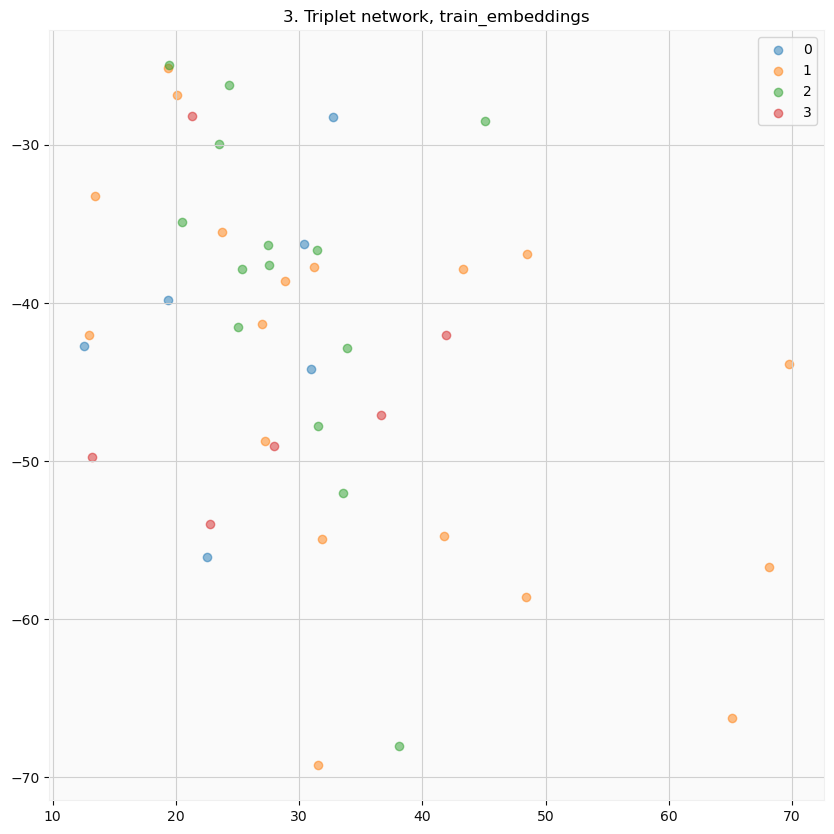

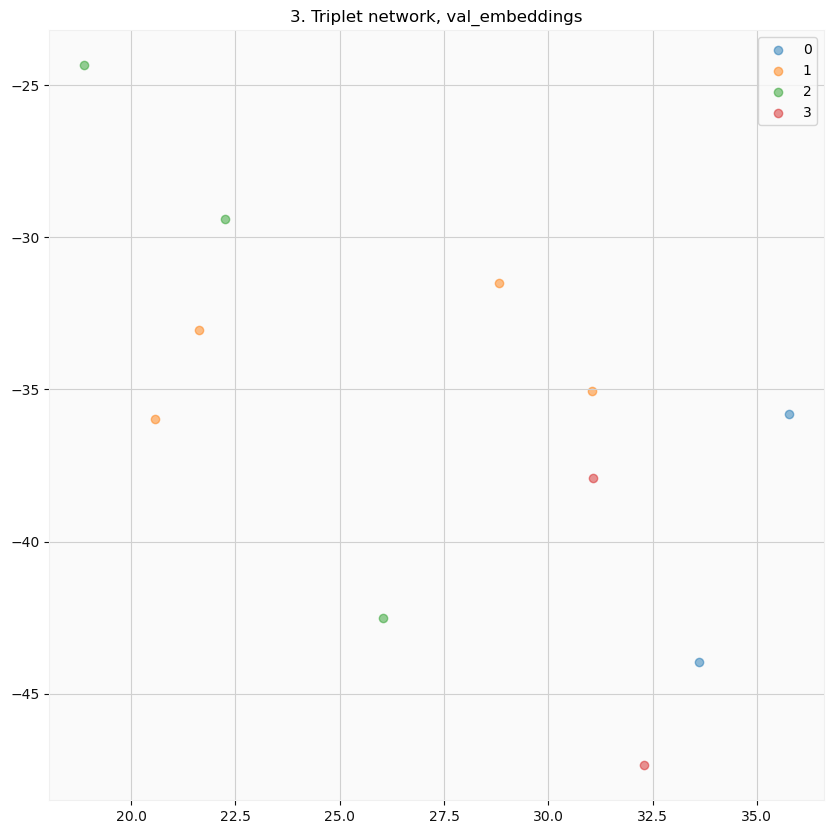

In [38]:
# Triplet network
# We'll train a triplet network, that takes an anchor, positive (same class as anchor)
# and negative (different class than anchor) examples.
# The objective is to learn embeddings such that the anchor is closer to the positive example
# than it is to the negative example by some margin value.
title = '3. Triplet network'
print(f'\n{title}:')
# Set up data loaders
triplet_train_dataset = TripletMNIST(x=x_train, y=y_train, train=True) # Returns triplets of images
triplet_test_dataset = TripletMNIST(x=x_test, y=y_test, train=False)
batch_size = 16
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
margin = 1.
embedding_net = EmbeddingNet().double()
model = TripletNet(embedding_net).double()
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 5
log_interval = 100

fit(triplet_train_loader, triplet_test_loader, model,
     loss_fn, optimizer, scheduler, n_epochs, cuda,
       log_interval)

train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl, f'{title}, train_embeddings')
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl, f'{title}, val_embeddings')


4. Online pair selection - negative mining:
Train: [0/44 (0%)]	Loss: 16.451607

Epoch: 1/20. Train set: Average loss: 4575.2037
Epoch: 1/20. Validation set: Average loss: 361.7877
Train: [0/44 (0%)]	Loss: 436.280942

Epoch: 2/20. Train set: Average loss: 841.1309
Epoch: 2/20. Validation set: Average loss: 482.8077
Train: [0/44 (0%)]	Loss: 479.029306

Epoch: 3/20. Train set: Average loss: 290.2854
Epoch: 3/20. Validation set: Average loss: 108.0854
Train: [0/44 (0%)]	Loss: 317.094438

Epoch: 4/20. Train set: Average loss: 268.8851
Epoch: 4/20. Validation set: Average loss: 88.8481
Train: [0/44 (0%)]	Loss: 171.304816

Epoch: 5/20. Train set: Average loss: 97.7744
Epoch: 5/20. Validation set: Average loss: 40.2145
Train: [0/44 (0%)]	Loss: 49.087564

Epoch: 6/20. Train set: Average loss: 82.1549
Epoch: 6/20. Validation set: Average loss: 55.5786
Train: [0/44 (0%)]	Loss: 132.692978

Epoch: 7/20. Train set: Average loss: 106.2915
Epoch: 7/20. Validation set: Average loss: 23.4839
Train: [0/

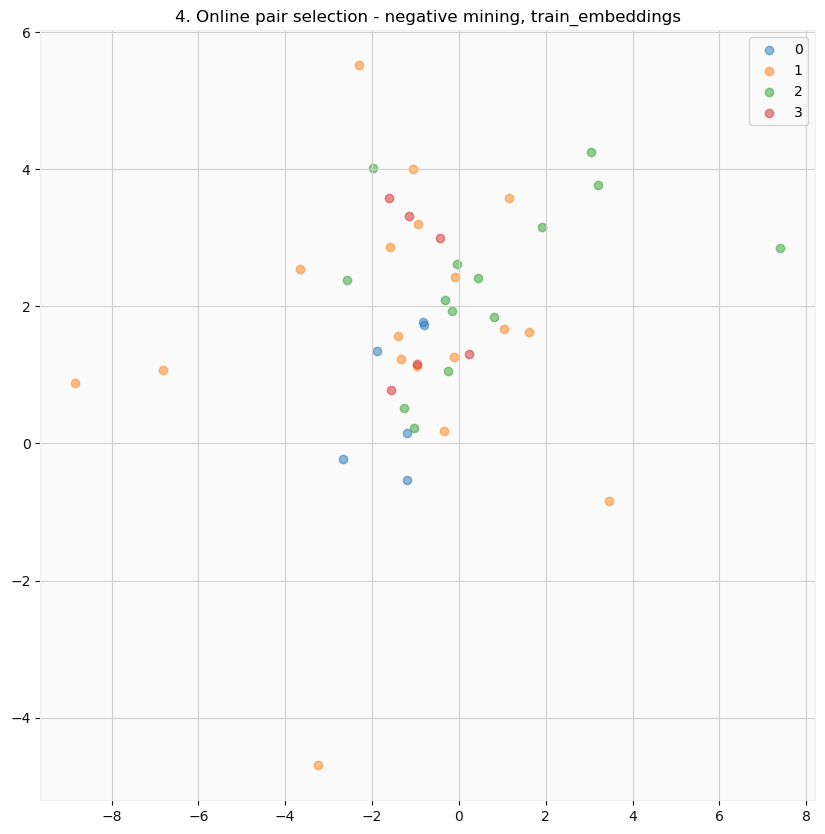

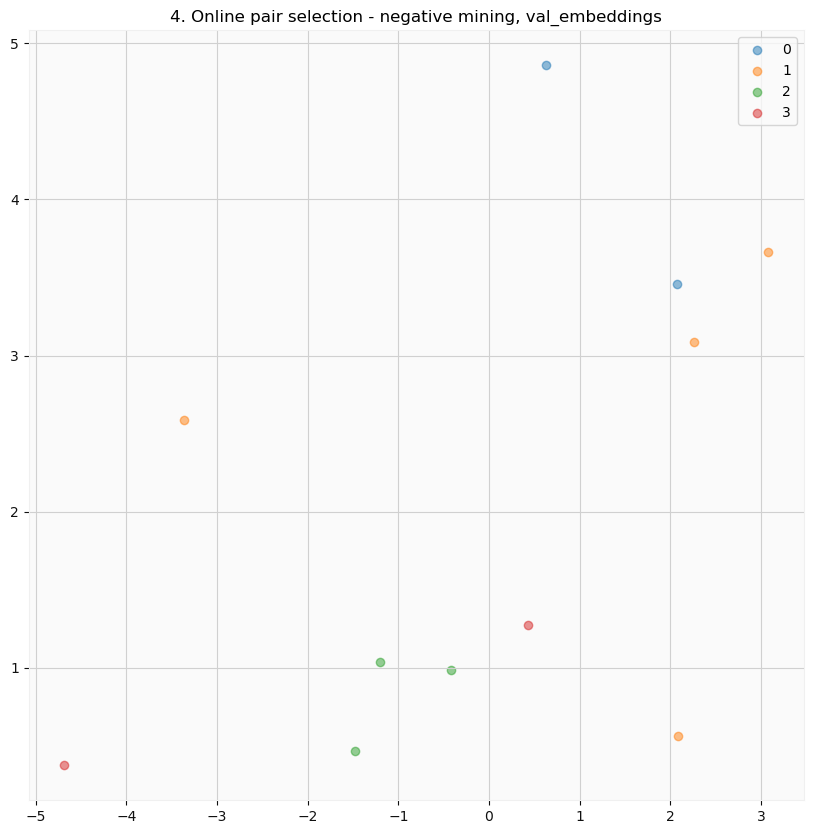

In [39]:
## Online pair selection
## Steps
# 1. Create BalancedBatchSampler - samples N  classes and M samples datasets.py
# 2. Create data loaders with the batch sampler Define embedding (mapping) network f(x) - EmbeddingNet from networks.py
# 3. Define a PairSelector that takes embeddings and original labels and returns valid pairs within a minibatch
# 4. Define OnlineContrastiveLoss that will use a PairSelector and compute ContrastiveLoss on such pairs
# 5. Train the network!
title = '4. Online pair selection - negative mining'
print(f'\n{title}:')
# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(y_train, n_classes=4, n_samples=4)
test_batch_sampler = BalancedBatchSampler(y_test, n_classes=4, n_samples=2)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
margin = 1.
embedding_net = EmbeddingNet().double()
model = embedding_net.double()
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

fit(online_train_loader, online_test_loader, model,
     loss_fn, optimizer, scheduler, n_epochs, cuda,
       log_interval)

train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, f'{title}, train_embeddings')
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl, f'{title}, val_embeddings')


5. Online triplet selection - negative mining:
Train: [0/44 (0%)]	Loss: 78.879590

Epoch: 1/20. Train set: Average loss: 78.8796
Epoch: 1/20. Validation set: Average loss: 16318.4071
Train: [0/44 (0%)]	Loss: 10956.690614

Epoch: 2/20. Train set: Average loss: 10956.6906
Epoch: 2/20. Validation set: Average loss: 1356.3756
Train: [0/44 (0%)]	Loss: 1164.193365

Epoch: 3/20. Train set: Average loss: 1164.1934
Epoch: 3/20. Validation set: Average loss: 713.7046
Train: [0/44 (0%)]	Loss: 1804.789997

Epoch: 4/20. Train set: Average loss: 1804.7900
Epoch: 4/20. Validation set: Average loss: 377.5493
Train: [0/44 (0%)]	Loss: 866.762151

Epoch: 5/20. Train set: Average loss: 866.7622
Epoch: 5/20. Validation set: Average loss: 634.3808
Train: [0/44 (0%)]	Loss: 787.783539

Epoch: 6/20. Train set: Average loss: 787.7835
Epoch: 6/20. Validation set: Average loss: 330.9803
Train: [0/44 (0%)]	Loss: 835.520932

Epoch: 7/20. Train set: Average loss: 835.5209
Epoch: 7/20. Validation set: Average loss: 

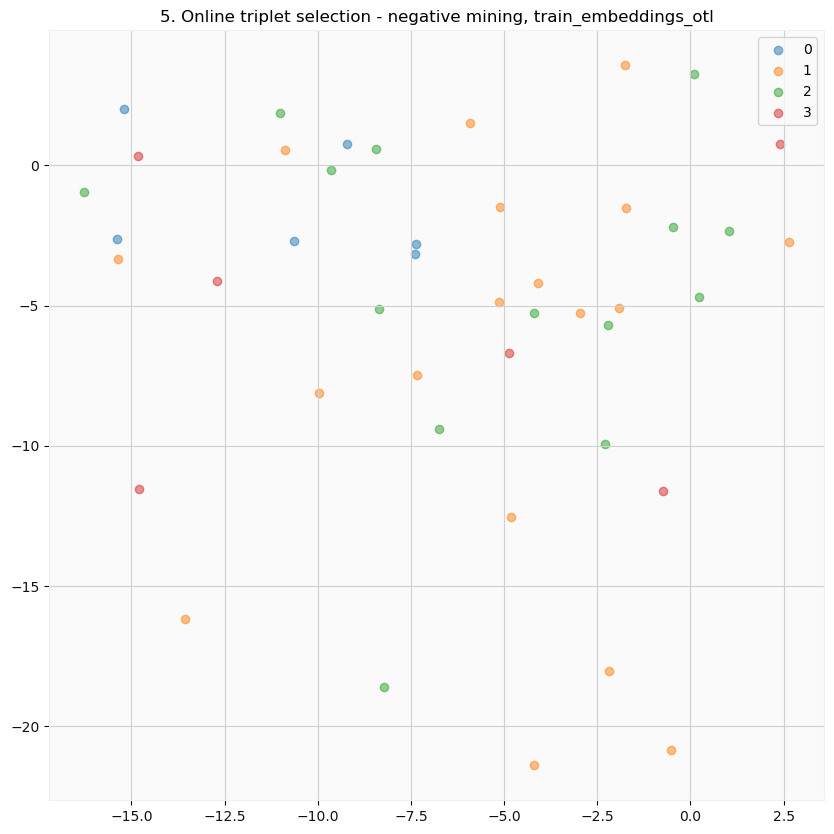

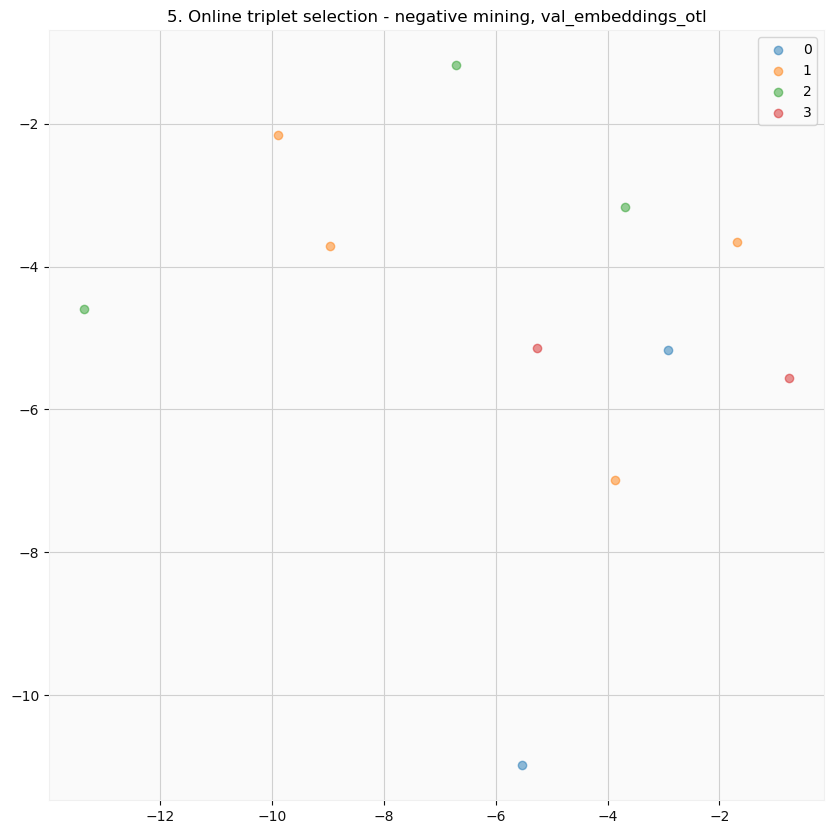

In [40]:

## Online triplet selection
## Steps
# 1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
# 2. Create data loaders with the batch sampler
# 3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
# 4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
# 5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
# 6. Train the network!
title = '5. Online triplet selection - negative mining'
print(f'\n{title}:')
# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(y_train, n_classes=4, n_samples=8)
test_batch_sampler = BalancedBatchSampler(y_test, n_classes=4, n_samples=2)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
margin = 1.
embedding_net = EmbeddingNet().double()
model = embedding_net.double()
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl, f'{title}, train_embeddings_otl')
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl, f'{title}, val_embeddings_otl')